# 4) Text generation with RNN models

In order to run this section the Notebook properly, the file `glove.6B.100d.txt`(GloVe - vector dimension 100, trained on Wikipedia 2014 and Gigaword 5) should be downloaded from the GloVe link provided below and inserted in the repository.

The aim of this section is to use a sample of stand-up comedy scripts to train 2 word-level models with a recurrent neural network (RNN) architecture and test their ability to generate new text $^{*}$. This means constructing models that use text sequences of a defined lenght as features to predict the next word in the sequence (i.e., y labels). In practice, the model is trained to predict the "class" of the next word in the sequence among the entire set of classes (i.e., all the words in the vocabulary).

It must be noticed that this type of task is computationally very expensive and requires a significant amount of data and training time to reach high levels of accuracy. In addition, the complexity of stand-up comedy text (i.e., rich vocabulary compared to script lenght, lots of slang/acronyms) exacerbates further this aspect.

For these reasons, I have adopted a number of measures to make the analysis feasible. First, only a subset of few similar documents has been used to train the models (specifically, all scripts included in the smallest cluster identified by k-means in section 3). Second, I kept the architecture of the RNN models as simple as possible to increase computational efficiency and reduce training time. Third, for similar reasons, I decided to use pre-trained weights from [GloVe](https://nlp.stanford.edu/projects/glove/) to embed text sequences for the deep learning models as this step dramatically reduces the number of model parameters to train.

In sum, this section is made of 4 steps:
- 4.1) Select the stand-up comedy scripts belonging to one of the clusters identified with K-means in section 3.3. Format and transform this sample of similar stand-up comedy scripts into a series of 50-words text sequences (features) followed by the 51st word in sequence (label). Each token in these sequences is then encoded as an integer. Using the encoded sequences, create training and validation sets for the models.
- 4.2) Build a pre-trained embedding matrix to pass to the deep learning models. This is done by extracting pre-trained word vectors from the Global Vectors for Word Representation text file (GloVe - vector dimension 100, trained on Wikipedia 2014 and Gigaword 5) using the word lookup table (i.e. word-integers lookup table built in 4.1). These vectors are then used as the weights of the embedding matrix in the Keras Embedding layer. This step allows to reduce sizebly the number of parameters to train for each model.
- 4.3) Define and train two RNN models (one based on LSTM cells and the other on GRU cells). After, compare their validation accuracy.
- 4.4) Use the most performing RNN model (the one with higher validation accuracy) to generate new text and confront it with the real sequence from the script.


$^{*}$ *For this section, I have drawn direct inspiration and fundamental help from the work of [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/).*

In [48]:
# General libraries
from tqdm import tqdm
import os
import re
import string
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from collections import Counter

# Feature engineering
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import random
from random import randint

# Model creation, training and text generation
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from pickle import load

# Describe machine details and turn-off future warnings
from tensorflow.python.client import device_lib
print( 'Machine specifics:', '\n', device_lib.list_local_devices())
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

Machine specifics: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12623663323006143249
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1463015835
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16144087352801582025
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


## 4.1) Create sequences from text

In [49]:
# Extract text and make a unique list
scripts = list(df['Text'])

# Select small subsample of similar documents for text generation
clust_to_use = min(cluster_desc, key=cluster_desc.get) # select cluster with smaller number of documents
docs_idx_gen = list(np.where(text_lbl==clust_to_use)[0])

subset_scripts = [scripts[i] for i in docs_idx_gen]

print('Number of total documents (stand-up comedy scripts):', len(scripts))
print('\nNumber of scripts included in the subset:', len(subset_scripts))
print('\nList of scripts used:\n\n', df.loc[docs_idx_gen, 'Title'])

Number of total documents (stand-up comedy scripts): 143

Number of scripts included in the subset: 9

List of scripts used:

 11                    Arsenio Hall: Smart & Classy
24     Cedric the Entertainer: Live from the Ville
26                           Chris Rock: Tamborine
33                 Dave Chappelle: Sticks & Stones
83                    Katt Williams: Great America
90                      Leslie Jones: Time Machine
96                         Marlon Wayans: Woke-ish
122                      Sam Jay: 3 in the Morning
134                    Tracy Morgan: Staying Alive
Name: Title, dtype: object


In [50]:
## Define function to retain punctuation in text sequences
## and treat them as a "words" in the model

def keep_punct(script):
    """Add spaces around punctuation"""

    # Add spaces around punctuation
    script = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', script)

    # Remove double spaces
    script = re.sub(r'\s\s', ' ', script)
    return script

In [51]:
## Apply functions to retain punctuation in scripts 
formatted_docs = []

# Iterate through scripts
for s in subset_scripts:
    formatted_docs.append(keep_punct(s))

print('{} documents have been formatted to be transformed in sequences.'.format(len(formatted_docs)))

9 documents have been formatted to be transformed in sequences.


In [52]:
## Define function to transform formatted text in sequences for training

# Set parameters
SEQUENCE_LENGHT = 50

def create_sequences(texts, training_length=SEQUENCE_LENGHT, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'The number of unique words in the vocabulary is {num_words}.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more tokens then the specified training length
    seq_lengths = [len(x) for x in sequences]
    over_idx = [i for i, l in enumerate(seq_lengths) if l > (training_length + 20)]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than sequence length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences with a lenght of at least {SEQUENCE_LENGHT} words.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

In [53]:
# Create training sequences

word_idx, idx_word, num_words, word_counts, new_texts, sequences, features, labels = create_sequences(formatted_docs, lower=True)

The number of unique words in the vocabulary is 5767.
There are 72792 training sequences with a lenght of at least 50 words.


### Define training and validation sets

In [54]:
## Define function to split sequences in train and validation sets

# Set parameters
TRAIN_FRACTION = 0.7
RANDOM_STATE = 50

def create_train_valid(features, labels, num_words, train_fraction=TRAIN_FRACTION):
    
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert features to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    
    # One-hot encode labels
    y_train = to_categorical(train_labels, num_classes=num_words)
    y_valid = to_categorical(valid_labels, num_classes=num_words)

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [55]:
# Apply function and split sequences

X_train, X_valid, y_train, y_valid = create_train_valid(features, labels, num_words)

print('Training set features shape:', X_train.shape)
print('Training set labels shape:', y_train.shape, '\n')
print('Validation set features shape:', X_valid.shape)
print('Validation set labels shape:', y_valid.shape)

Training set features shape: (50954, 50)
Training set labels shape: (50954, 5767) 

Validation set features shape: (21838, 50)
Validation set labels shape: (21838, 5767)


## 4.2) Load pre-trained embeddings from GloVe and create embeddings matrix

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings. For this reason, words in the vocabulary for which a pre-trained vector is not present have been set to zero.

In [56]:
# Load in unzipped file
glove_vectors = 'GloVe_embed\glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', encoding='utf-8', comments=None)

print('Number of words vectors:', glove.shape[0], ', Size word vectors: ', glove.shape[1])

Number of words vectors: 400000 , Size word vectors:  101


In [57]:
# Separate vectors and labels
vectors = glove[:, 1:].astype('float')
words_label = glove[:, 0]

# Free up space
del glove

# Print example of word and its vector
vectors[10], words_label[10]

(array([-1.4401e-01,  3.2554e-01,  1.4257e-01, -9.9227e-02,  7.2536e-01,
         1.9321e-01, -2.4188e-01,  2.0223e-01, -8.9599e-01,  1.5215e-01,
         3.5963e-02, -5.9513e-01, -5.1635e-02, -1.4428e-02,  3.5475e-01,
        -3.1859e-01,  7.6984e-01, -8.7369e-02, -2.4762e-01,  6.5059e-01,
        -1.5138e-01, -4.2703e-01,  1.8813e-01,  9.1562e-02,  1.5192e-01,
         1.1303e-01, -1.5222e-01, -6.2786e-01, -2.3923e-01,  9.6009e-02,
        -4.6147e-01,  4.1526e-01, -3.0475e-01,  1.3710e-01,  1.6758e-01,
         5.3301e-01, -4.3658e-02,  8.5924e-01, -4.1192e-01, -2.1394e-01,
        -5.1228e-01, -3.1945e-01,  1.2662e-01, -3.1510e-01,  3.1429e-03,
         2.7129e-01,  1.7328e-01, -1.3159e+00, -4.2414e-01, -6.9126e-01,
         1.9017e-02, -1.3375e-01, -9.6057e-02,  1.7069e+00, -6.5291e-01,
        -2.6111e+00,  2.6518e-01, -6.1178e-01,  2.0950e+00,  3.8148e-01,
        -5.5823e-01,  2.0360e-01, -3.3704e-01,  3.7354e-01,  6.9510e-01,
        -1.6370e-03,  8.1885e-01,  5.1793e-01,  2.7

In [58]:
# Word lookup dictionary
word_lookup = {word: vector for word, vector in zip(words_label, vectors)}

# Define shape embedding matrix with vocaboulary size and vector size
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

# Filter GloVe vectors to keep only those words that appear in the vocaboulary
# N.B. the value of zero will be assigned to the words for which an embedding is not found
not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1        

print(f'There are {not_found} words without pre-trained embeddings.')

# Normalize and convert NaN values to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))

embedding_matrix = np.nan_to_num(embedding_matrix)

print('Shape embedding matrix:', embedding_matrix.shape)

There are 712 words without pre-trained embeddings.
Shape embedding matrix: (5767, 100)


In [59]:
# Free up memory space
import gc
gc.enable()
del vectors
gc.collect()

0

## 4.3) Contruct and train LTSM-RNN models

### 4.3.1) Define baseline for comparison

In order to have a term of comparison for the performance of the RNN models, I created a baseline model to make predictions over the validation labels (i.e., y_valid) using word frequencies. The average validation accuracy when predicting the next word in the validation set by using the most frequent word in the vocabulary is around 3.5%.

In [60]:
# Define baseline for comparison
np.random.seed(40)

# Number of all words
total_words = sum(word_counts.values())

# Compute frequency of each word in vocab
frequencies = [word_counts[word] / total_words for word in word_idx.keys()]
frequencies.insert(0, 0)

# Print top 10 most frequent words
frequencies[1:11], list(word_idx.keys())[0:10]

([0.03541683733377024,
  0.03347805903716447,
  0.0326588569400071,
  0.024289342180715982,
  0.020766773162939296,
  0.020657546216651647,
  0.01526446574369897,
  0.014718331012260725,
  0.01328472734223533,
  0.0113322956773436],
 ['you', 'i', 'the', 'to', 'and', 'a', 'that', 'like', 'in', 'it'])

In [61]:
# Print baseline model validation accuracy
print(f'The accuracy is {round(100 * np.mean(np.argmax(y_valid, axis = 1) == 1), 3)}%.')

The accuracy is 3.581%.


### 4.3.2) Model 1 - RNN with LTSM cells

Model 1 is a neural network based on a layer of 64 LSTM cells (see model summary for complete description of the layers). 

Unlike standard feedforward neural networks, LSTM is an artificial neural network that has feedback connections. LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. This makes LSTM suitable for predictions on sequential data such as time series or, in this case, text sequences.

The validation accuracy reached by this model is around 11.5%.

In [62]:
## Define Model_1

# Set parameters
LSTM_CELLS = 64
EPOCHS = 150
BATCH_SIZE = 1000
VERBOSE = 1

# Define architecture 
model_1 = Sequential()
model_1.add(Embedding(input_dim=num_words, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False, mask_zero=True))
model_1.add(Masking())
model_1.add(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model_1.add(BatchNormalization())
#model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_words, activation='softmax'))

print(model_1.summary())

# Compile model
#opt = keras.optimizers.Adam(lr=0.01)
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set Early stopping and reduce learning rate callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         576700    
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5767)              374855    
Total params: 994,051
Trainable params: 417,223
Non-trainable params: 576,828
________________________________________________________________

In [63]:
# Fit model
hist_model_1 = model_1.fit(X_train, y_train, batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=VERBOSE,
                           callbacks=[early_stopping, reduce_lr],
                           validation_data=(X_valid, y_valid))

Train on 50954 samples, validate on 21838 samples
Epoch 1/150
50954/50954 [==============================] - 18s 354us/step - loss: 8.5778 - acc: 0.0174 - val_loss: 8.5390 - val_acc: 0.0471
Epoch 2/150
50954/50954 [==============================] - 10s 205us/step - loss: 8.1267 - acc: 0.0464 - val_loss: 8.1868 - val_acc: 0.0517
Epoch 3/150
50954/50954 [==============================] - 10s 201us/step - loss: 7.3619 - acc: 0.0616 - val_loss: 7.6581 - val_acc: 0.0637
Epoch 4/150
50954/50954 [==============================] - 10s 201us/step - loss: 6.6438 - acc: 0.0770 - val_loss: 7.0002 - val_acc: 0.0588
Epoch 5/150
50954/50954 [==============================] - 10s 201us/step - loss: 6.1340 - acc: 0.0834 - val_loss: 6.5247 - val_acc: 0.0545
Epoch 6/150
50954/50954 [==============================] - 10s 202us/step - loss: 5.8428 - acc: 0.0876 - val_loss: 6.2686 - val_acc: 0.0578
Epoch 7/150
50954/50954 [==============================] - 10s 203us/step - loss: 5.6799 - acc: 0.0894 - val_l

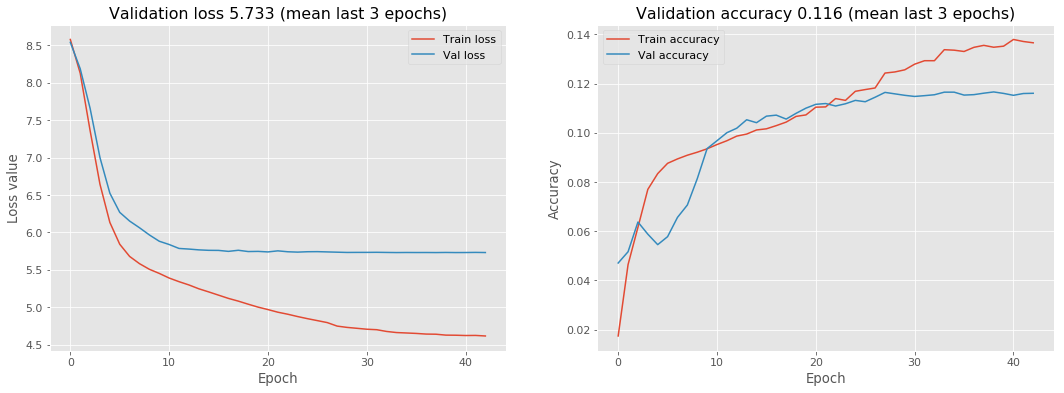

In [64]:
# Plot loss value and accuracy graphs

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot accuracy values
ax1.plot(hist_model_1.history['loss'], label='Train loss')
ax1.plot(hist_model_1.history['val_loss'], label='Val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_1.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(hist_model_1.history['acc'], label='Train accuracy')
ax2.plot(hist_model_1.history['val_acc'], label='Val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_1.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 4.3.3) Model 2 - RNN with GRU cells

Model 2 is a neural network based on 1 layer of 64 GRU cells (see model summary for complete description of the layers). 

Similarly to LSTM cells, Gated Recurrent Units (GRU) have a forget gate but fewer parameters to estimate as they lack an output gate. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets so they could be ideal for this case.

The validation accuracy reached by this model is around 11%.

In [65]:
## Define Model_2

# Set parameters
GRU_CELLS = 64
EPOCHS = 150
BATCH_SIZE = 1000
VERBOSE = 1


# Define architecture 
model_2 = Sequential()
model_2.add(Embedding(input_dim=num_words, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False, mask_zero=True))
model_2.add(Masking())
#model_2.add(Bidirectional(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model_2.add(GRU(GRU_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model_2.add(BatchNormalization())
#model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(num_words, activation='softmax'))

print(model_2.summary())

# Compile model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set Early stopping and reduce learning rate callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         576700    
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
gru (GRU)                    (None, 64)                31680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5767)              374855    
Total params: 983,491
Trainable params: 406,663
Non-trainable params: 576,828
________________________________________________________________

In [66]:
# Fit model
hist_model_2 = model_2.fit(X_train, y_train, batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=VERBOSE,
                           callbacks=[reduce_lr, early_stopping],
                           validation_data=(X_valid, y_valid))

Train on 50954 samples, validate on 21838 samples
Epoch 1/150
50954/50954 [==============================] - 18s 346us/step - loss: 8.5457 - acc: 0.0238 - val_loss: 8.5263 - val_acc: 0.0367
Epoch 2/150
50954/50954 [==============================] - 13s 258us/step - loss: 8.0035 - acc: 0.0559 - val_loss: 8.1671 - val_acc: 0.0422
Epoch 3/150
50954/50954 [==============================] - 12s 238us/step - loss: 7.2479 - acc: 0.0709 - val_loss: 7.6150 - val_acc: 0.0643
Epoch 4/150
50954/50954 [==============================] - 11s 217us/step - loss: 6.5528 - acc: 0.0817 - val_loss: 6.9810 - val_acc: 0.0598
Epoch 5/150
50954/50954 [==============================] - 10s 203us/step - loss: 6.1147 - acc: 0.0853 - val_loss: 6.5235 - val_acc: 0.0571
Epoch 6/150
50954/50954 [==============================] - 10s 194us/step - loss: 5.8423 - acc: 0.0878 - val_loss: 6.2773 - val_acc: 0.0598
Epoch 7/150
50954/50954 [==============================] - 10s 187us/step - loss: 5.6807 - acc: 0.0905 - val_l

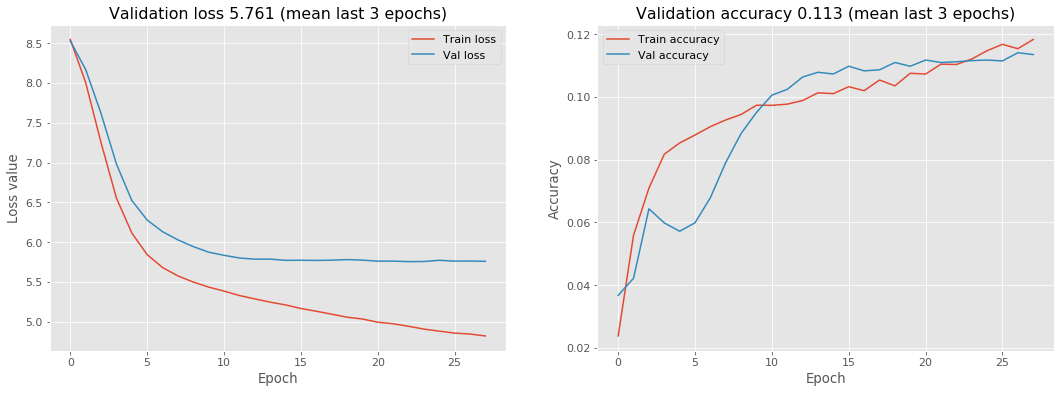

In [67]:
# Plot loss value and accuracy graphs

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot accuracy values
ax1.plot(hist_model_2.history['loss'], label='Train loss')
ax1.plot(hist_model_2.history['val_loss'], label='Val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_2.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(hist_model_2.history['acc'], label='Train accuracy')
ax2.plot(hist_model_2.history['val_acc'], label='Val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_2.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 4.3.4) Comparison of models performance

The two RNN models reach very similar levels of validation accuracy. It does not seem therefore that GRU cells have an accuracy advantage in this case.

In general, the level of validation accuracy reached by the RNN models is not very high. As mentioned at the beginning of the section, the prediction task is quite complex and, for computational reasons, training sample had to be kept small. Both models are therefore trying to predict the right class/next word in the sequence out of more than 5500 classes/words using a training sample of 50000 sequences. This means, on average, that for each of the 5700 classes there are less than 10 examples present in the training data.

Nevertheless, we can see that in a short amount of time (and with a small amount of data) both RNN models become 3 times more accurate in predicting text sequences compared to the baseline model.

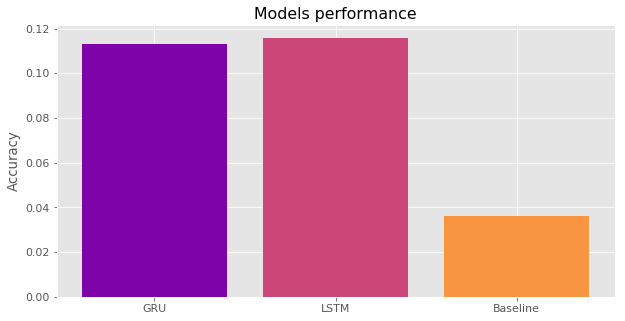

In [68]:
## Model performance bar chart

accuracy = [np.mean(hist_model_2.history['val_acc'][-3:]), # Model 2 - GRU
            np.mean(hist_model_1.history['val_acc'][-3:]), # Model 1 - LSTM
            round(np.mean(np.argmax(y_valid, axis = 1) == 1), 3)] # Baseline accuracy

models = ['GRU', 'LSTM', 'Baseline']

# Plot
plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig = plt.figure(figsize=(10, 5))#set subplot and fig size

plt.bar(np.arange(3), accuracy, color=sns.color_palette("plasma", 3))
plt.xticks(np.arange(3), models, ha="center")
plt.ylabel('Accuracy')
plt.title("Models performance")

plt.show()

## 4.4) Generate text

Finally, the best performing RNN model has been employed to generate new text. In this exercise, I fed the trained RNN model with a seed sequence of text from the stand-up comedy scripts, have it make a prediction, add the predicted word to the sequence, and make another prediction for the next word. This process continues for the number of words that we want (the new_words parameter regulates this).

The comparison between the new generated text by the model and the actual sequence of text shows that the model is still far from generating meaningful human-like text. However, it is interesting to notice that despite its low level of validation accuracy, the model is still capable to produce funny sentences (although not very meaningful!).

As already mentioned, it must be noted that the model was trained on a relatively small sample (around 50000 observations) of complex text (vocabulary with over 5000 words/classes to predict) for around 30 epochs. This means that, similarly to other application cases of deep learning, the volume of data and the amount of computational power are key to improve the generation capabilities of the model.

In [69]:
# Define function to remove spaces around punctuation
def remove_spaces(script):
    '''Remove spaces around punctuation'''
    script = re.sub(r'\s+([.,;?])', r'\1', script)

    return script

In [70]:
# Define function to generate text

def generate_text(model, sequences, training_length=50, new_words=50, diversity=1, return_output=False, n_gen=1):
    
    '''Generate new text using trained model'''

    # Choose a random text sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)

    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

            # Diversify
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual script
        n = []

        for i in generated:
            n.append(idx_word.get(i, '===>'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '===>'))

    a = a[training_length:]

    gen_list = [gen[training_length:training_length + len(a)] for gen in gen_list]

    if return_output:
        return original_sequence, gen_list, a

    # Print output
    seed_header = print('\033[1m' + 'Randomly drawn seed sequence:' + '\033[0m', '\n')
    seed_text = print(remove_spaces(' '.join(original_sequence)), '\n\n')

    gen_header = print('\033[91m' + 'Model 1 LSTM - Generated:' + '\033[0m', '\n')
    gen_text =  print(remove_spaces(' '.join(gen_list[0])), '\n')

    actual_header = print('\033[92m' + 'Actual text:' + '\033[0m', '\n')
    actual_text = print(remove_spaces(' '.join(a)), '\n')

    return seed_header, seed_text, gen_header, gen_text, actual_header, actual_text

In [71]:
seed_header, seed_text, gen_header, gen_text, actual_header, actual_text = generate_text(model_1, sequences, SEQUENCE_LENGHT)

Randomly drawn seed sequence: 

yeah that's gay you can't do that no more little shit like dudes you can't be talkin' to another dude on the phone and hung up talkin' about byebye that's gay man we can't say byebye to another dude dawg trip man being a father and i was talkin' about 


Model 1 LSTM - Generated: 

===> i realized i heard i'm a man i brought a dream because every was all and the time he did that an dick you got a picture of bullies a kid like how nigga struggling the most mall can is talkin' going to pack run space to right to pack 

Actual text: 

===> all the young kids with their communicating right there 'cause i've been married 16 years man i been trying my wife still be tryin' to keep a hot thing yeah my baby she a good babe too we be tryin' to keep the shit fresh so i be tryin' to 

